# **Задача**

Предсказать задержку рейса более чем на 15 минут

Загрузим библиотеки и данные

In [1]:
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as ctb
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
sns.set()
%config InlineBackend.figure_format = 'retina'

In [2]:
train = pd.read_csv('../input/focus-start-2020/flight_delays_train.csv')
test = pd.read_csv('../input/focus-start-2020/flight_delays_test.csv')
train.head()

,month,day_of_month,day_of_week,dep_time,unique_carrier,origin,dest,distance,dep_delayed_15min
0,4,16,4,1309,OO,GEG,SLC,546,0
1,3,11,3,1118,UA,LAX,ORD,1744,0
2,4,2,4,558,WN,PDX,DEN,991,0
3,5,28,4,1540,OO,GFK,MSP,284,0
4,7,17,5,718,AA,CLT,PHL,449,0


# **EDA**

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124397 entries, 0 to 124396
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   month              124397 non-null  int64 
 1   day_of_month       124397 non-null  int64 
 2   day_of_week        124397 non-null  int64 
 3   dep_time           124397 non-null  int64 
 4   unique_carrier     124397 non-null  object
 5   origin             124397 non-null  object
 6   dest               124397 non-null  object
 7   distance           124397 non-null  int64 
 8   dep_delayed_15min  124397 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 8.5+ MB


Выборка немного несбалансирована.

In [4]:
train["dep_delayed_15min"].value_counts()

0    102482
1     21915
Name: dep_delayed_15min, dtype: int64

Пропущенных значений нет.

In [5]:
train.isnull().sum()

month                0
day_of_month         0
day_of_week          0
dep_time             0
unique_carrier       0
origin               0
dest                 0
distance             0
dep_delayed_15min    0
dtype: int64

Посмотрим зависимости таргета от разных признаков.

1.На выходных меньше полетов и меньше задержек, особенно в субботу.

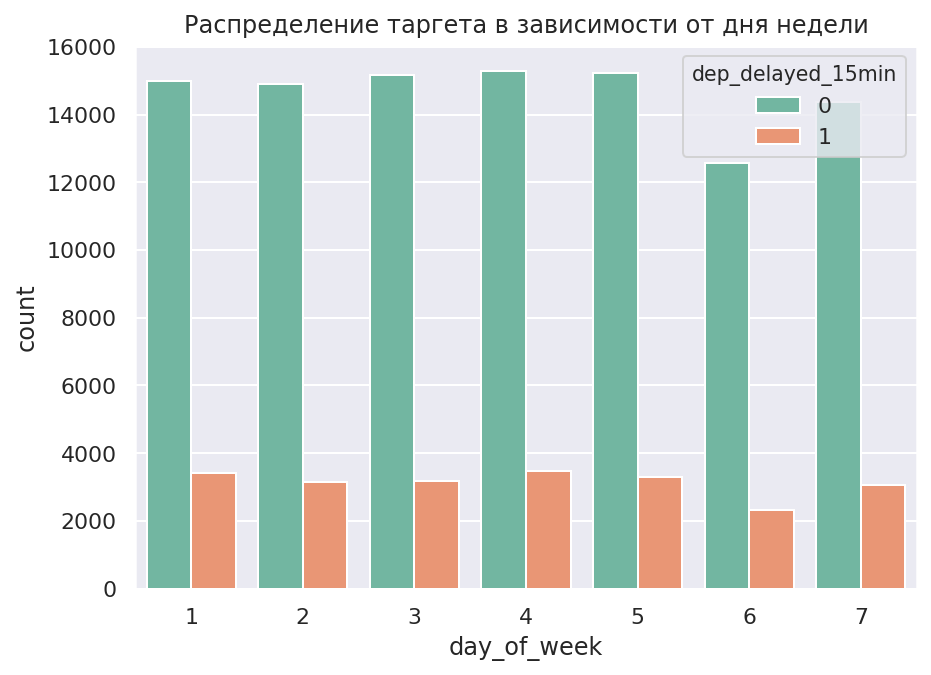

In [6]:
fig, ax = plt.subplots(figsize=(7,5))
plt.title('Распределение таргета в зависимости от дня недели')
sns.countplot(x='day_of_week', hue='dep_delayed_15min', data=train[["day_of_week", "dep_delayed_15min"]], palette="Set2");

2. Здесь тоже видно,что на выходных задержек меньше

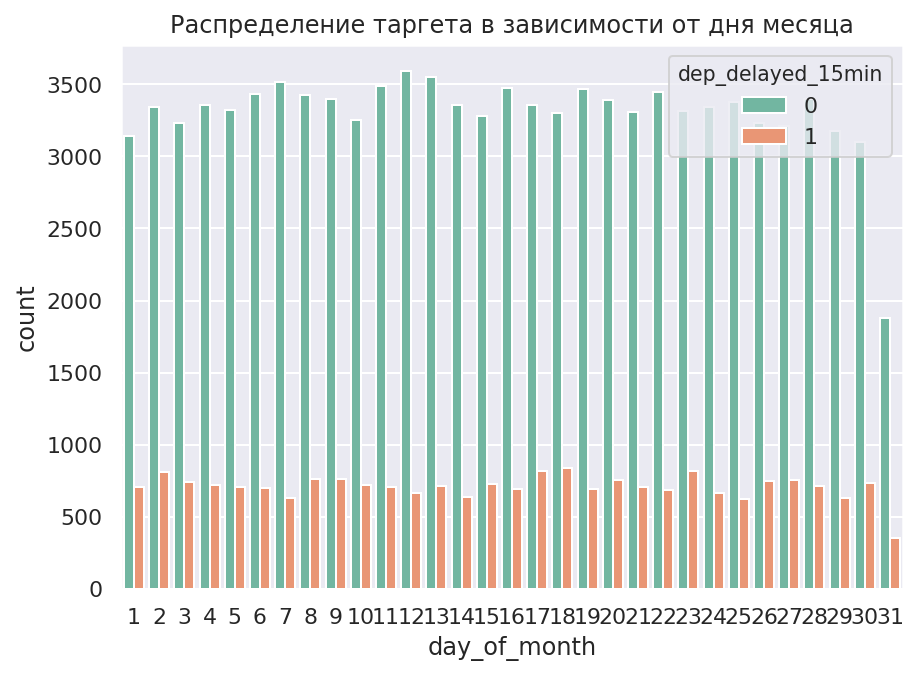

In [7]:
fig, ax = plt.subplots(figsize=(7,5))
plt.title('Распределение таргета в зависимости от дня месяца')
sns.countplot(x='day_of_month', hue='dep_delayed_15min', data=train[["day_of_month", "dep_delayed_15min"]], palette="Set2");

3. В летние месяцы задержек рейсов больше всего, осенью меньше всего

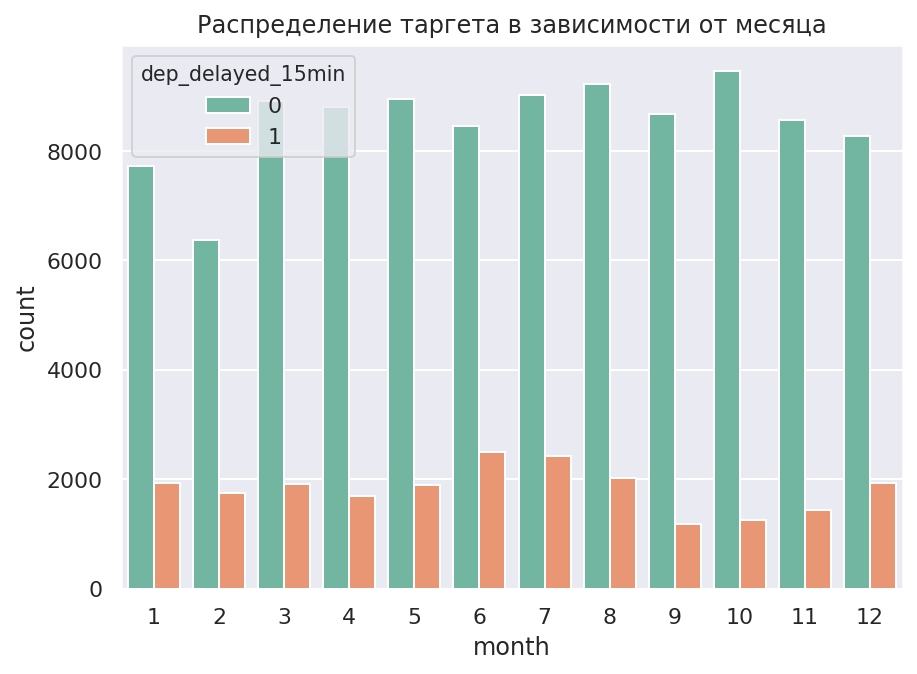

In [8]:
fig, ax = plt.subplots(figsize=(7,5))
plt.title('Распределение таргета в зависимости от месяца')
sns.countplot(x='month', hue='dep_delayed_15min', data=train[["month", "dep_delayed_15min"]], palette="Set2");

4. Зависимость от авиаперевозчика

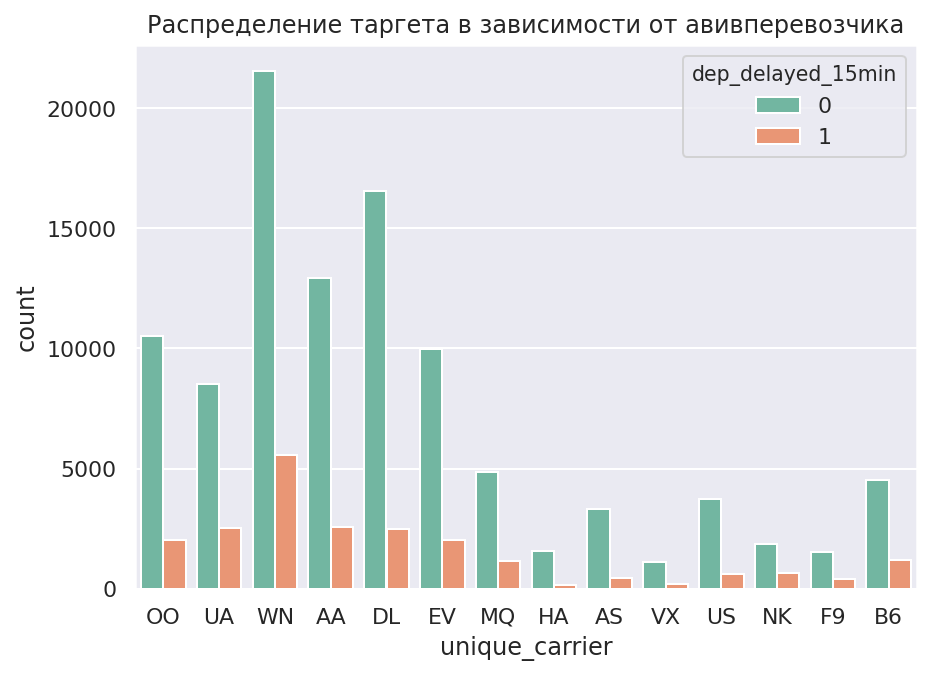

In [9]:
fig, ax = plt.subplots(figsize=(7,5))
plt.title('Распределение таргета в зависимости от авивперевозчика')
sns.countplot(x='unique_carrier', hue='dep_delayed_15min', data=train[["unique_carrier", "dep_delayed_15min"]], palette="Set2");

5. Откуда чаще всего вылетают самолеты с задержкой?

In [10]:
train[train["dep_delayed_15min"] == 1].groupby("origin")["dep_delayed_15min"].count().sort_values(ascending=False).head(20)

origin
ORD    1298
ATL    1266
DFW    1089
DEN     921
LAX     873
SFO     644
IAH     618
LAS     593
PHX     554
MCO     532
EWR     501
LGA     442
BWI     418
JFK     410
MDW     389
CLT     374
BOS     371
DTW     368
SEA     358
MSP     345
Name: dep_delayed_15min, dtype: int64

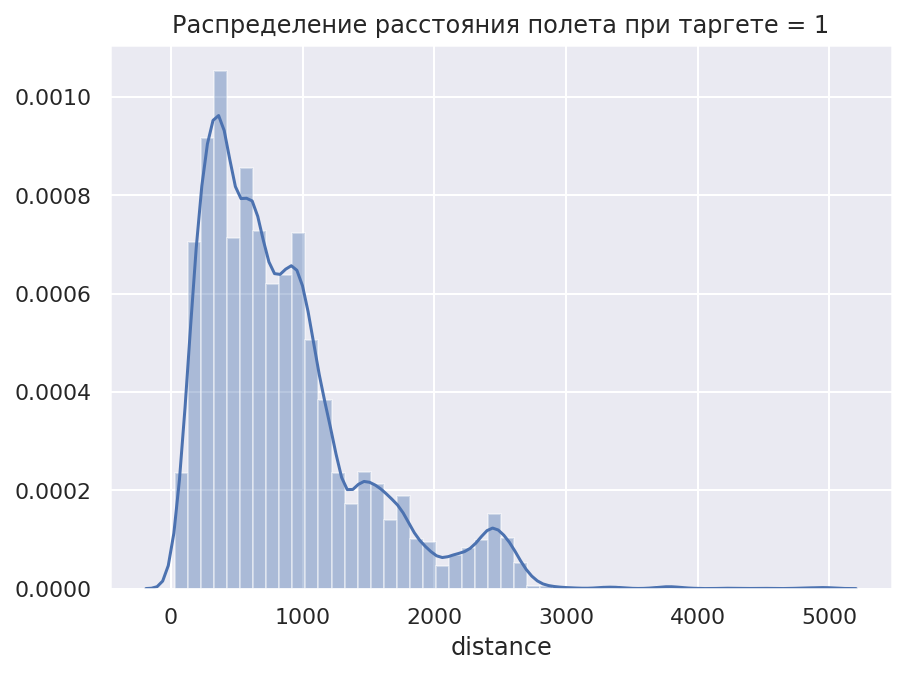

In [11]:
fig, ax = plt.subplots(figsize=(7,5))
plt.title('Распределение расстояния полета при таргете = 1')
sns.distplot(train[train["dep_delayed_15min"] == 1]["distance"]);

# **Повторим baseline**

In [12]:
X_train = train.drop("dep_delayed_15min", axis = 1).values
y_train = train['dep_delayed_15min']
X_test = test.values

In [13]:
X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.3, random_state=42)

In [14]:
ctb = CatBoostClassifier(random_seed=42)
cat_features_idx = np.where(train.dtypes == 'object')[0].tolist()
cat_features_idx

[4, 5, 6]

In [15]:
ctb.fit(X_train_part, y_train_part, logging_level='Silent', cat_features=cat_features_idx)
ctb_valid_pred = ctb.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, ctb_valid_pred)

0.7555228286067397

# **Добавим новые признаки**

Признак1 - выходной или нет.

In [16]:
train["Weekend"] = train["day_of_week"].apply(lambda x: 1 if x == 6 or x == 7 else 0)
test["Weekend"] = test["day_of_week"].apply(lambda x: 1 if x == 6 or x == 7 else 0)

Признак 2 - из времени отлета сделаем признаки Час и Минута

In [17]:
train["minute"] = (train["dep_time"]%100)
train["hour"] = (train["dep_time"]/100).astype(int)
test["minute"] = (test["dep_time"]%100)
test["hour"] = (test["dep_time"]/100).astype(int)

Признак 3 - из месяца сделаем сезон Весна,Зима,Лето или Осень(бинарные)

In [18]:
train["winter"] = train["month"].apply(lambda x: 1 if x in ["1", "2", "12"] else 0)
train["spring"] = train["month"].apply(lambda x: 1 if x in ["3", "4", "5"] else 0)
train["summer"] = train["month"].apply(lambda x: 1 if x in ["6","7","8"] else 0)
train["autumn"] = train["month"].apply(lambda x: 1 if x in ["9","10","11"] else 0)
test["winter"] = test["month"].apply(lambda x: 1 if x in ["1", "2", "12"] else 0)
test["spring"] = test["month"].apply(lambda x: 1 if x in ["3", "4", "5"] else 0)
test["summer"] = test["month"].apply(lambda x: 1 if x in ["6","7","8"] else 0)
test["autumn"] = test["month"].apply(lambda x: 1 if x in ["9","10","11"] else 0)

Сделаем некоторые признаки категориальными

In [19]:
train["hour"] = train["hour"].astype(object)
test["hour"] = test["hour"].astype(object)

train["day_of_month"] = train["day_of_month"].astype(object)
train["day_of_week"] = train["day_of_week"].astype(object)
test["day_of_month"] = test["day_of_month"].astype(object)
test["day_of_week"] = test["day_of_week"].astype(object)

Признак 4 - Из времени сделаем бинарные признаки День, Вечер, Ночь, Утро

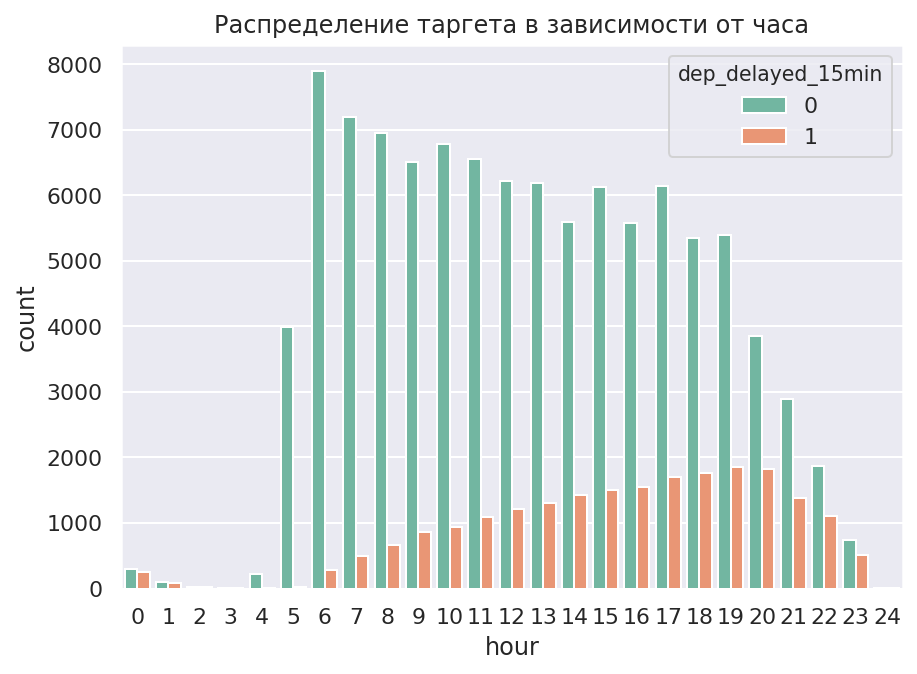

In [20]:
fig, ax = plt.subplots(figsize=(7,5))
plt.title('Распределение таргета в зависимости от часа')
sns.countplot(x='hour', hue='dep_delayed_15min', data=train[["hour", "dep_delayed_15min"]], palette="Set2");

In [21]:
train["morning"] = train["hour"].apply(lambda x: 1 if x in ["6", "7", "8", "9", "10", "11"] else 0)
train["day"] = train["hour"].apply(lambda x: 1 if x in ["12", "13", "14", "15", "16", "17"] else 0)
train["evening"] = train["hour"].apply(lambda x: 1 if x in ["18", "19", "20", "21", "22", "23"] else 0)
train["night"] = train["hour"].apply(lambda x: 1 if x in ["0", "1", "2", "3", "4", "5"] else 0)
test["morning"] = test["hour"].apply(lambda x: 1 if x in ["6", "7", "8", "9", "10", "11"] else 0)
test["day"] = test["hour"].apply(lambda x: 1 if x in ["12", "13", "14", "15", "16", "17"] else 0)
test["evening"] = test["hour"].apply(lambda x: 1 if x in ["18", "19", "20", "21", "22", "23"] else 0)
test["night"] = test["hour"].apply(lambda x: 1 if x in ["0", "1", "2", "3", "4", "5"] else 0)

По распределению расстояния полетов на графике для задержанных рейсов решила добавить такой параметр - расстояние меньше 3000

In [22]:
train["dist3000"] = train["distance"].apply(lambda x: 1 if x <= 3000 else 0)
test["dist3000"] = test["distance"].apply(lambda x: 1 if x <= 3000 else 0)

In [23]:
columns = train.columns[train.dtypes == 'object']
columns

Index(['day_of_month', 'day_of_week', 'unique_carrier', 'origin', 'dest',
       'hour'],
      dtype='object')

In [24]:
X_train = train.drop("dep_delayed_15min", axis = 1).values
y_train = train['dep_delayed_15min']
X_test = test.values

In [25]:
X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.3, random_state=42)

In [26]:
ctb = CatBoostClassifier(random_seed=42)
cat_features_idx = np.where(train.drop("dep_delayed_15min", axis = 1).dtypes == 'object')[0].tolist()
cat_features_idx

[1, 2, 4, 5, 6, 10]

In [27]:
ctb.fit(X_train_part, y_train_part, logging_level='Silent', cat_features=cat_features_idx)
ctb_valid_pred = ctb.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, ctb_valid_pred)

0.8040931494717665

# **Попробуем подобрать параметры catboost с помощью GridSearchCV**
Чтобы не повторять подбор параметров,я закоментила эту секцию, но параметры подобрались такие:
0.7814390162735102, {'depth': 7, 'l2_leaf_reg': 7, 'learning_rate': 0.1})

In [28]:
#params = {'depth': [4, 7, 10],
#          'learning_rate' : [0.1, 1],
#         'l2_leaf_reg': [1, 7, 9]}
#ctb = CatBoostClassifier(random_seed=42)
#ctb_gscv = GridSearchCV(ctb, params, scoring="roc_auc", cv=3, n_jobs=-1)
#ctb_gscv.fit(X_train_part, y_train_part,logging_level='Verbose', cat_features=cat_features_idx)

Я еще немного вручную попробовала разные learning rate и получился такой результат

In [29]:
ctb = CatBoostClassifier(random_seed=42, depth=7, l2_leaf_reg=7, learning_rate=0.2)
ctb.fit(X_train_part, y_train_part, logging_level='Silent', cat_features=cat_features_idx)
ctb_valid_pred = ctb.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, ctb_valid_pred)

0.8088496461093962

Обучаемся на всех train данных и делаем прогноз

In [30]:
ctb.fit(X_train, y_train, logging_level='Silent', cat_features=cat_features_idx)
ctb_test_pred = ctb.predict_proba(X_test)[:, 1]

In [31]:
pd.Series(ctb_test_pred, 
          name='Predicted').to_csv('ctb_test_pred_12.csv', 
                                           index_label='id', header=True)

На каггле на тестовых данных открытых получилось 0.82709


# **Попробуем Light GBM**

In [32]:
import lightgbm
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124397 entries, 0 to 124396
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   month              124397 non-null  int64 
 1   day_of_month       124397 non-null  object
 2   day_of_week        124397 non-null  object
 3   dep_time           124397 non-null  int64 
 4   unique_carrier     124397 non-null  object
 5   origin             124397 non-null  object
 6   dest               124397 non-null  object
 7   distance           124397 non-null  int64 
 8   dep_delayed_15min  124397 non-null  int64 
 9   Weekend            124397 non-null  int64 
 10  minute             124397 non-null  int64 
 11  hour               124397 non-null  object
 12  winter             124397 non-null  int64 
 13  spring             124397 non-null  int64 
 14  summer             124397 non-null  int64 
 15  autumn             124397 non-null  int64 
 16  morning            1

In [33]:
y_train = train['dep_delayed_15min']
train = train.drop("dep_delayed_15min", axis = 1)

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124397 entries, 0 to 124396
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   month           124397 non-null  int64 
 1   day_of_month    124397 non-null  object
 2   day_of_week     124397 non-null  object
 3   dep_time        124397 non-null  int64 
 4   unique_carrier  124397 non-null  object
 5   origin          124397 non-null  object
 6   dest            124397 non-null  object
 7   distance        124397 non-null  int64 
 8   Weekend         124397 non-null  int64 
 9   minute          124397 non-null  int64 
 10  hour            124397 non-null  object
 11  winter          124397 non-null  int64 
 12  spring          124397 non-null  int64 
 13  summer          124397 non-null  int64 
 14  autumn          124397 non-null  int64 
 15  morning         124397 non-null  int64 
 16  day             124397 non-null  int64 
 17  evening         124397 non-nu

Я не очень разобралась, но light gbm не принял у меня категориальные данные без кодирования, поэтому делаю кодирование 
по типу мешка слов.

In [35]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)
train.shape, test.shape

((124397, 1286), (72000, 1234))

Так как размерности разные, и не получалось сделать предсказание на тестовых данных, я удалила из трейна те колонки, которых нет в тесте, и наоборот.

In [36]:
result=list(set(train.columns) - set(test.columns))
result
train = train.drop(result, axis = 1)
result=list(set(test.columns) - set(train.columns))
result
test = test.drop(result, axis = 1)
train.shape, test.shape

((124397, 1210), (72000, 1210))

In [37]:
X_train = train.values
X_test = test.values

Эти параметры уже после GridSearchcv

In [38]:
X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.3, random_state=42)

train_data = lightgbm.Dataset(X_train_part, label=y_train_part)
test_data = lightgbm.Dataset(X_valid, label=y_valid)
param = {'num_leaves': 150, 
         'objective': 'binary', 
         'metric': 'auc',
         'learning_rate': 0.1,
         'n_estimators': 200,
         'num_iterations': 300 }

In [39]:
lgbm = lightgbm.LGBMClassifier(**param)
lgbm.fit(X_train_part, y_train_part,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        early_stopping_rounds=100)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.706585
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.712726
[3]	valid_0's auc: 0.715648
[4]	valid_0's auc: 0.717556
[5]	valid_0's auc: 0.71896
[6]	valid_0's auc: 0.72127
[7]	valid_0's auc: 0.723827
[8]	valid_0's auc: 0.725853
[9]	valid_0's auc: 0.727844
[10]	valid_0's auc: 0.730493
[11]	valid_0's auc: 0.731672
[12]	valid_0's auc: 0.732519
[13]	valid_0's auc: 0.733533
[14]	valid_0's auc: 0.734097
[15]	valid_0's auc: 0.735123
[16]	valid_0's auc: 0.736105
[17]	valid_0's auc: 0.737436
[18]	valid_0's auc: 0.738269
[19]	valid_0's auc: 0.739233
[20]	valid_0's auc: 0.739781
[21]	valid_0's auc: 0.74075
[22]	valid_0's auc: 0.741259
[23]	valid_0's auc: 0.74195
[24]	valid_0's auc: 0.742545
[25]	valid_0's auc: 0.743428
[26]	valid_0's auc: 0.743725
[27]	valid_0's auc: 0.745553
[28]	valid_0's auc: 0.746432
[29]	valid_0's auc: 0.746977
[30]	valid_0's auc: 0.747282
[31]	valid_0's auc: 0.747895
[32]	valid_0's auc: 0.749276
[33]	valid_0's auc: 0.7

LGBMClassifier(metric='auc', n_estimators=200, num_iterations=300,
               num_leaves=150, objective='binary')

In [40]:
lgbm.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('auc', 0.7574443139332647)])})

In [41]:
lgbm_test_pred = lgbm.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, lgbm_test_pred)

0.7574443139332648

Вот тут подбирала параметры

In [42]:
gridParams = {
    'learning_rate': [0.1],
    'n_estimators': [200],
    'objective' : ['binary'],
    'num_leaves': [256, 150]
    }
grid = GridSearchCV(lgbm, gridParams, verbose=3, cv=4, n_jobs=-1)
grid.fit(X_train_part, y_train_part, eval_set=[(X_valid, y_valid)],
        eval_metric='auc')

Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:   23.2s remaining:   23.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   38.7s finished
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.706585
[2]	valid_0's auc: 0.712726
[3]	valid_0's auc: 0.715648
[4]	valid_0's auc: 0.717556
[5]	valid_0's auc: 0.71896
[6]	valid_0's auc: 0.72127
[7]	valid_0's auc: 0.723827
[8]	valid_0's auc: 0.725853
[9]	valid_0's auc: 0.727844
[10]	valid_0's auc: 0.730493
[11]	valid_0's auc: 0.731672
[12]	valid_0's auc: 0.732519
[13]	valid_0's auc: 0.733533
[14]	valid_0's auc: 0.734097
[15]	valid_0's auc: 0.735123
[16]	valid_0's auc: 0.736105
[17]	valid_0's auc: 0.737436
[18]	valid_0's auc: 0.738269
[19]	valid_0's auc: 0.739233
[20]	valid_0's auc: 0.739781
[21]	valid_0's auc: 0.74075
[22]	valid_0's auc: 0.741259
[23]	valid_0's auc: 0.74195
[24]	valid_0's auc: 0.742545
[25]	valid_0's auc: 0.743428
[26]	valid_0's auc: 0.743725
[27]	valid_0's auc: 0.745553
[28]	valid_0's auc: 0.746432
[29]	valid_0's auc: 0.746977
[30]	valid_0's auc: 0.747282
[31]	valid_0's auc: 0.747895
[32]	valid_0's auc: 0.749276
[33]	valid_0's auc: 0.750149
[34]	valid_0's auc: 0.750749
[35]	valid_0's auc: 0.75110

GridSearchCV(cv=4,
             estimator=LGBMClassifier(metric='auc', n_estimators=200,
                                      num_iterations=300, num_leaves=150,
                                      objective='binary'),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'n_estimators': [200],
                         'num_leaves': [256, 150], 'objective': ['binary']},
             verbose=3)

In [43]:
grid.best_params_

{'learning_rate': 0.1,
 'n_estimators': 200,
 'num_leaves': 150,
 'objective': 'binary'}

In [44]:
lgbm_test_pred = grid.best_estimator_.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, lgbm_test_pred)

0.756587762922543

Посмотрим на первые 40 важных признаков.

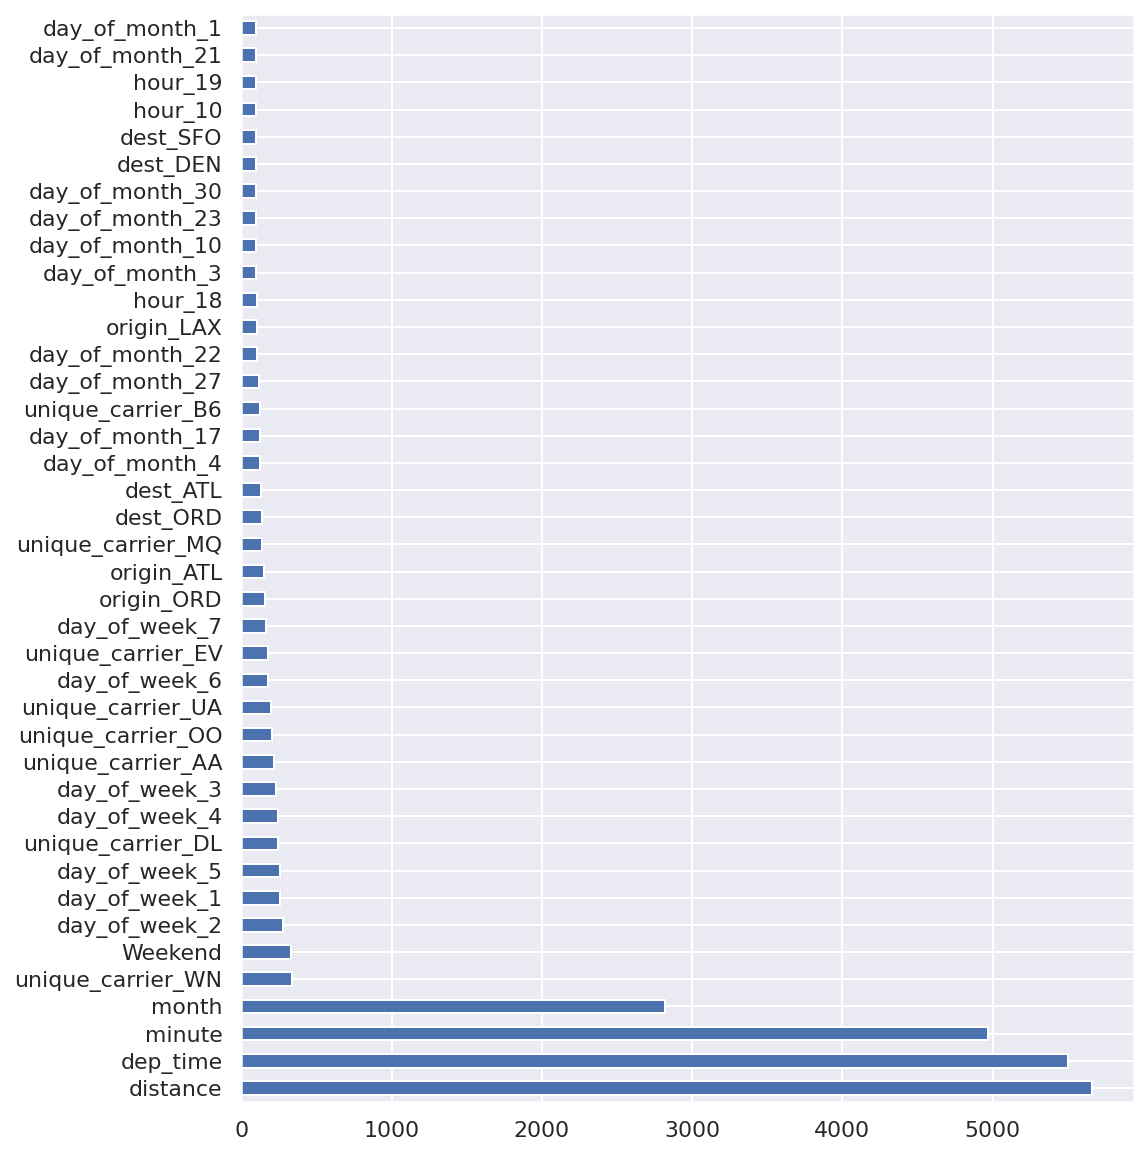

In [45]:
feat_imp = pd.Series(lgbm.feature_importances_, index=train.columns)
feat_imp.nlargest(40).plot(kind='barh', figsize=(8,10));

In [46]:
lgbm.fit(X_train_part, y_train_part,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        early_stopping_rounds=100)
lgbm_test_pred = lgbm.predict_proba(X_test)[:, 1]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.706585
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.712726
[3]	valid_0's auc: 0.715648
[4]	valid_0's auc: 0.717556
[5]	valid_0's auc: 0.71896
[6]	valid_0's auc: 0.72127
[7]	valid_0's auc: 0.723827
[8]	valid_0's auc: 0.725853
[9]	valid_0's auc: 0.727844
[10]	valid_0's auc: 0.730493
[11]	valid_0's auc: 0.731672
[12]	valid_0's auc: 0.732519
[13]	valid_0's auc: 0.733533
[14]	valid_0's auc: 0.734097
[15]	valid_0's auc: 0.735123
[16]	valid_0's auc: 0.736105
[17]	valid_0's auc: 0.737436
[18]	valid_0's auc: 0.738269
[19]	valid_0's auc: 0.739233
[20]	valid_0's auc: 0.739781
[21]	valid_0's auc: 0.74075
[22]	valid_0's auc: 0.741259
[23]	valid_0's auc: 0.74195
[24]	valid_0's auc: 0.742545
[25]	valid_0's auc: 0.743428
[26]	valid_0's auc: 0.743725
[27]	valid_0's auc: 0.745553
[28]	valid_0's auc: 0.746432
[29]	valid_0's auc: 0.746977
[30]	valid_0's auc: 0.747282
[31]	valid_0's auc: 0.747895
[32]	valid_0's auc: 0.749276
[33]	valid_0's auc: 0.7

In [47]:
pd.Series(lgbm_test_pred, 
          name='Predicted').to_csv('lgbt_test_pred_11.csv', 
                                           index_label='id', header=True)

На каггле получилось 0.76195
Результаты lgbm у меня хуже.Думаю, я не очень правильно подала ему категориальные признаки. Пробовала также ограничивать признаки по feature_importances. Это не дало улучшения метрики. Пробовала также one-hot encoding - не дало улучшений.